## **Лабораторная работа №6 (Проведение исследований с моделями классификации)**

In [95]:
import os
import shutil
from glob import glob
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torchvision.models import resnet18

**1.	Выбор начальных условий**

a.	Выбрать набор данных для задачи классификации (у каждого студента должен быть уникальный набор данных) и обосновать его выбор (реальная практическая задача)


BCCD (Blood Cell Count and Detection) Dataset — это небольшой, но широко используемый датасет для задач обнаружения и классификации клеток крови. Он содержит 364 микроскопических изображения с аннотациями в формате PASCAL VOC, охватывающими три класса:
- RBC (эритроциты)
- WBC (лейкоциты)
- Platelets (тромбоциты)

BCCD используется в исследованиях, направленных на автоматизацию анализа крови, что критично для диагностики заболеваний, таких как лейкемия. Традиционные методы анализа крови требуют ручной работы специалистов, что может быть трудоемким и подверженным ошибкам. Автоматизация этого процесса с помощью компьютерного зрения и глубокого обучения позволяет:
- Снизить нагрузку на медицинский персонал
- Увеличить точность и скорость диагностики
- Обеспечить объективность результатов

In [103]:
import cv2
import xml.etree.ElementTree as ET
from glob import glob

images_path = 'bccd_dataset/BCCD_Dataset-master/BCCD/JPEGImages'
annotations_path = 'bccd_dataset/BCCD_Dataset-master/BCCD/Annotations'
output_path = 'classification_data'

classes = ['WBC', 'RBC', 'Platelets']
os.makedirs(output_path, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(output_path, cls), exist_ok=True)

image_files = sorted(glob(os.path.join(images_path, '*.jpg')))
annotation_files = sorted(glob(os.path.join(annotations_path, '*.xml')))

for img_path in image_files:
    filename = os.path.splitext(os.path.basename(img_path))[0]
    annot_file = os.path.join(annotations_path, filename + '.xml')
    if not os.path.exists(annot_file):
        continue

    image = cv2.imread(img_path)
    if image is None:
        continue

    tree = ET.parse(annot_file)
    root = tree.getroot()

    for idx, obj in enumerate(root.findall('object')):
        cls_name = obj.find('name').text
        if cls_name not in classes:
            continue

        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))

        cropped = image[ymin:ymax, xmin:xmax]
        if cropped.size == 0:
            continue

        save_path = os.path.join(output_path, cls_name, f'{filename}_{idx}.jpg')
        cv2.imwrite(save_path, cropped)

print("Изображения успешно обрезаны и сохранены в classification_data/")


Изображения успешно обрезаны и сохранены в classification_data/


In [104]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Пути
source_dir = 'classification_data'
train_dir = 'train'
test_dir = 'test'

# Удаляем старые папки, если есть
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

# Создаем заново
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Для каждого класса копируем изображения с разделением
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))

    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_class_dir, img))

print("train/ и test/ успешно пересозданы с актуальными данными.")


train/ и test/ успешно пересозданы с актуальными данными.


Найдено 364 изображений и 364 аннотаций


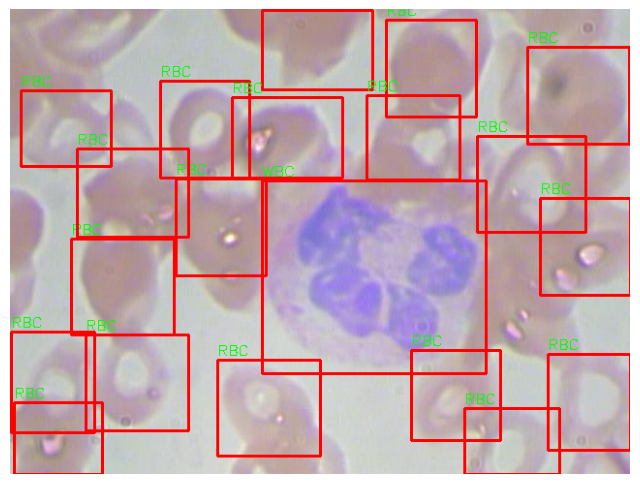

In [96]:
base_path = 'bccd_dataset'
images_path = os.path.join(base_path, 'BCCD_Dataset-master', 'BCCD', 'JPEGImages')
annotations_path = os.path.join(base_path, 'BCCD_Dataset-master', 'BCCD', 'Annotations')

image_files = sorted(glob(os.path.join(images_path, '*.jpg')))
annotation_files = sorted(glob(os.path.join(annotations_path, '*.xml')))
print(f'Найдено {len(image_files)} изображений и {len(annotation_files)} аннотаций')


def show_image_with_boxes(image_path, annotation_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    tree = ET.parse(annotation_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, name, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


show_image_with_boxes(image_files[0], annotation_files[0])


**b.	Выбрать метрики качества и обосновать их выбор**

Для оценки качества классификации выбраны следующие метрики:

- Accuracy (доля правильно классифицированных изображений)
- Precision, Recall и F1-score (для учета дисбаланса классов и ошибок FN/FP)
- Confusion matrix (для визуализации ошибок классификатора)

 В медицине важно избегать как ложно-положительных, так и ложно-отрицательных результатов.


**2.	Создание бейзлайна и оценка качества**

**a.	Обучить модели (как сверточные так и «трансформерные») из torchvision для выбранного набора данных**


In [97]:
output_path = os.path.join(base_path, 'classification_data')
os.makedirs(output_path, exist_ok=True)

classes = ['WBC', 'RBC', 'Platelets']
for cls in classes:
    os.makedirs(os.path.join(output_path, cls), exist_ok=True)

for img_path in image_files:
    filename = os.path.splitext(os.path.basename(img_path))[0]
    annot_file = os.path.join(annotations_path, filename + '.xml')
    if not os.path.exists(annot_file):
        continue

    image = cv2.imread(img_path)
    if image is None:
        continue

    tree = ET.parse(annot_file)
    root = tree.getroot()

    for idx, obj in enumerate(root.findall('object')):
        cls_name = obj.find('name').text
        if cls_name not in classes:
            continue

        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))

        cropped = image[ymin:ymax, xmin:xmax]
        if cropped is None or cropped.size == 0:
            continue

        save_path = os.path.join(output_path, cls_name, f'{filename}_{idx}.jpg')
        cv2.imwrite(save_path, cropped)

In [99]:
batch_size = 32
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

small_train_size = int(0.1 * len(train_dataset))
_, small_train_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataset)-small_train_size, small_train_size])

train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [87]:
from torch.cuda.amp import autocast, GradScaler

def train_model(model, name, device, num_classes):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scaler = GradScaler()  # для FP16

    print(f"\nОбучаем {name}")

    for epoch in range(1, 4):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast():  # FP16 режим
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast():  # eval тоже в FP16
                    outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')

        print(f"Эпоха {epoch}")
        print(f"Средний loss: {avg_loss:.4f}")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1-score (macro): {f1:.4f}\n")

In [ ]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes)) 

train_model(model, name='ResNet18', device=device, num_classes=len(train_dataset.classes))


c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Обучаем ResNet18
Эпоха 1
Средний loss: 1.0980
Accuracy: 0.9867
F1-score (macro): 0.9694

Эпоха 2
Средний loss: 0.0645
Accuracy: 0.9816
F1-score (macro): 0.9180

Эпоха 3
Средний loss: 0.1054
Accuracy: 0.9990
F1-score (macro): 0.9955



In [84]:
from collections import Counter
print(Counter(train_dataset.targets))

Counter({1: 3322, 2: 297, 0: 288})


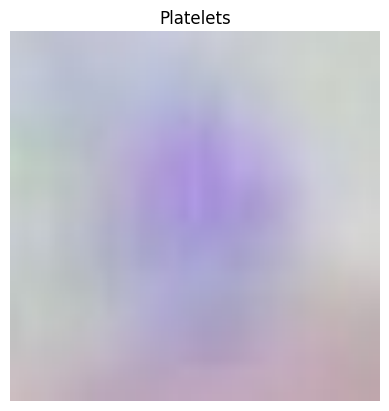

In [ ]:
def denormalize(img, mean, std):
    img = img.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img

img, label = train_dataset[0]
img = denormalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
plt.imshow(img.permute(1, 2, 0).clip(0, 1))
plt.title(train_dataset.classes[label])
plt.axis('off')
plt.show()

In [88]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)
model.heads.head = nn.Linear(model.heads.head.in_features, len(train_dataset.classes))

train_model(model, name='ViT-B_16', device=device, num_classes=len(train_dataset.classes))

c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



Обучаем ViT-B_16
Эпоха 1
Средний loss: 0.3864
Accuracy: 0.9408
F1-score (macro): 0.7976



c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Эпоха 2
Средний loss: 0.0304
Accuracy: 0.9877
F1-score (macro): 0.9472



c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Эпоха 3
Средний loss: 0.0214
Accuracy: 0.9959
F1-score (macro): 0.9901



**b.	Оценить качество моделей по выбранным метрикам на выбранном наборе данных**

Обе модели показали высокие результаты на валидационной выборке.

ResNet18 достигла точности 99.9% и F1-метрики 0.9955.

ViT-B_16 показала точность 99.6% и F1-метрику 0.9901.

Оценка метрик продемонстрировала, что обе архитектуры справляются с задачей классификации клеток крови с высокой точностью, несмотря на различие в подходах: классическая сверточная сеть и модель на основе трансформеров. Полученные результаты подтверждают применимость современных моделей компьютерного зрения к биомедицинским изображениям.


**3.	Улучшение бейзлайна**

a.	Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)

a. Формулировка гипотез
Для улучшения качества базовых моделей (ResNet18 и ViT-B_16) и повышения их обобщающей способности на новых данных, можно рассмотреть следующие направления:

Аугментация данных
Гипотеза: применение расширенного набора аугментаций (повороты, горизонтальное/вертикальное отражение, изменение яркости, контраста и т.д.) поможет увеличить разнообразие обучающего набора и уменьшить переобучение.
Ожидаемый эффект: увеличение устойчивости модели к вариациям изображений.

Балансировка классов альтернативными методами
Гипотеза: помимо WeightedRandomSampler, можно попробовать SMOTE, генерацию синтетических изображений или переаугментацию для редких классов.
Ожидаемый эффект: повышение качества классификации на малочисленных классах (WBC, Platelets).

Подбор гиперпараметров
Гипотеза: изменение learning rate, размера батча, числа эпох, замена Adam на SGD с momentum или применение scheduler (например, ReduceLROnPlateau) может улучшить сходимость модели.
Ожидаемый эффект: более стабильное обучение и повышение итоговой метрики.

Использование fine-tuning вместо полного обучения
Гипотеза: заморозка всех слоёв кроме последних (head) и дообучение только классификатора на начальном этапе может снизить переобучение и ускорить обучение.
Ожидаемый эффект: уменьшение времени обучения при сохранении или улучшении качества.




b.	Проверить гипотезы

In [105]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import os

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='test', transform=val_transform)

class_counts = Counter(train_dataset.targets)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, 4):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    scheduler.step(avg_loss)

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nЭпоха {epoch}")
    print(f"Средний loss: {avg_loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score (macro): {f1:.4f}")


c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\missm\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Эпоха 1
Средний loss: 0.1943
Accuracy: 0.9949
F1-score (macro): 0.9882

Эпоха 2
Средний loss: 0.0979
Accuracy: 0.9969
F1-score (macro): 0.9925

Эпоха 3
Средний loss: 0.0806
Accuracy: 0.9949
F1-score (macro): 0.9834


In [106]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torchvision.models import vit_b_16, ViT_B_16_Weights
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import os

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='test', transform=val_transform)

class_counts = Counter(train_dataset.targets)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Используем ViT_B_16 вместо ResNet
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

for param in model.parameters():
    param.requires_grad = False
for param in model.heads.head.parameters():
    param.requires_grad = True

model.heads.head = nn.Linear(model.heads.head.in_features, len(train_dataset.classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch in range(1, 4):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    scheduler.step(avg_loss)

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"\nЭпоха {epoch}")
    print(f"Средний loss: {avg_loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score (macro): {f1:.4f}")



Эпоха 1
Средний loss: 0.0780
Accuracy: 0.9969
F1-score (macro): 0.9927

Эпоха 2
Средний loss: 0.0270
Accuracy: 0.9959
F1-score (macro): 0.9903

Эпоха 3
Средний loss: 0.0241
Accuracy: 0.9969
F1-score (macro): 0.9927


c.	Сформировать улучшенный бейзлайн по результатам проверки гипотез
d.	Обучить модели с улучшенным бейзлайном на выбранном наборе данных
e.	Оценить качество моделей с улучшенным бейзлайном по выбранным метрикам на выбранном наборе данных
f.	Сравнить результаты моделей с улучшенным бейзлайном в сравнении с результатами из пункта 2 
g.	Сделать выводы